In [1]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [50]:
plt.rcParams['font.size'] = '12'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [4]:
#!wget -O data/CITE-seq.zip https://figshare.com/ndownloader/articles/8309696/versions/2
#!unzip data/CITE-seq.zip -d data/CITE-seq/

In [5]:
#!wget -O data/10x_2018.zip https://figshare.com/ndownloader/articles/9912734/versions/1

In [6]:
#!unzip data/10x_2018.zip -d data/10x_2018/

In [4]:
rna = ad.read_loom('data/CITE-seq/SPBMC_run3.loom')
rna

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1789 × 33694
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

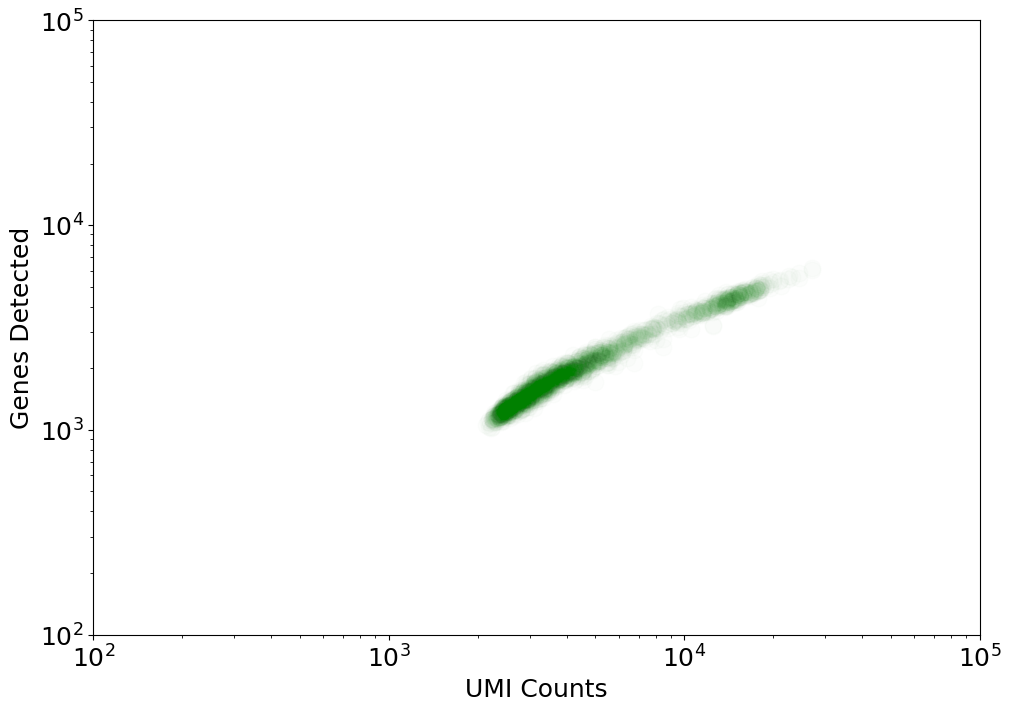

In [5]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['spliced'].toarray()+rna.layers['unspliced'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((100,100000))
ax.set_ylim((100,100000))

plt.show()

In [6]:
import statistics

statistics.median(mtx.sum(axis=1))

3624

In [7]:
rna.obs

,Clusters,_X,_Y
CellID,,,
SPBMC_run3:ACACCCTGTGGCTCCAx,0,-2.354522,-0.951643
SPBMC_run3:ACACTGAAGGCCCTCAx,0,-28.219820,-16.182312
SPBMC_run3:AACCGCGAGTACGCCCx,3,-27.644531,-14.055833
SPBMC_run3:AAGGAGCGTTGTACACx,5,-11.832486,-16.724150
SPBMC_run3:ACACCCTAGGAATTACx,5,-2.275564,18.236624
...,...,...,...
SPBMC_run3:TTGACTTAGTGACATAx,2,34.168129,5.704925
SPBMC_run3:TTGCGTCTCCCTAATTx,1,-18.508293,18.849865
SPBMC_run3:TTGTAGGCACAACTGTx,3,-12.252896,-24.070152


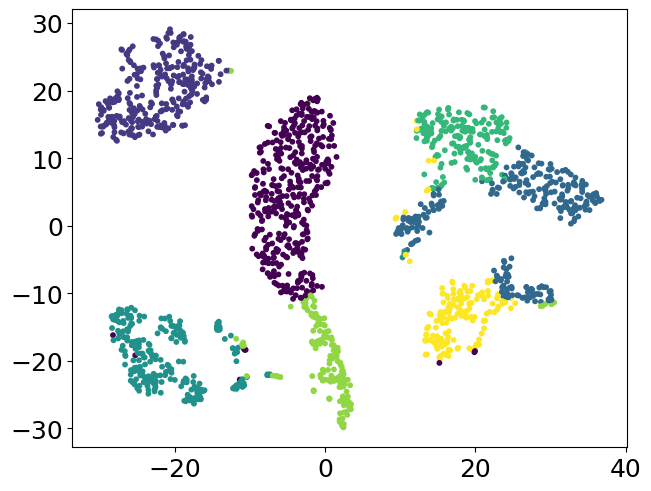

In [8]:
plt.scatter(rna.obs['_X'],rna.obs['_Y'],c=rna.obs['Clusters'],s=10)

In [9]:
protein = pd.read_csv('data/CITE-seq/GSE100866_PBMC_vs_flow_10X-ADT_umi.csv')
protein = protein.T
protein.columns = protein.iloc[0]
protein = protein[1:]
protein = ad.AnnData(protein)
protein

AnnData object with n_obs × n_vars = 7985 × 10

In [10]:
protein.obs_names

Index(['ACCGTAAGTGTAATGA', 'CGTGAGCTCGAGAACG', 'CACATTTAGAATTCCC',
       'TACGGTATCTGGGCCA', 'TCAGGTAGTAAGTTCC', 'TGATTTCGTTCTCATT',
       'ACACTGAAGGCCCTCA', 'ACGGGTCGTCACACGC', 'AGCTTGACATCCCATC',
       'ACGTCAATCCGTCATC',
       ...
       'TTCTCCTAGATCGATA', 'GGAAAGCGTCGACTAT', 'GACTAACCAACACCCG',
       'AGCGTCGTCCTCGCAT', 'TCTCATAAGTTTGCGT', 'GTCGGGTAGAGCTGGT',
       'GTCGGGTAGGTAGCCA', 'GTCGGGTAGTCTTGCA', 'ATGTGTGGTCCGTTAA',
       'CGTATGCCGTCTTCTG'],
      dtype='object', length=7985)

In [11]:
rna_bcd = rna.obs_names
protein_bcd = protein.obs_names
bcd = [ bc[11:-1]   for bc in rna_bcd]
common_bc = np.intersect1d(bcd,np.array(protein_bcd))
print(common_bc.shape)

protein_common_bc_idx = np.array([np.where(np.array(protein_bcd)==bc)[0][0] for bc in common_bc])
rna_common_bc_idx = np.array([np.where(np.array(bcd)==bc)[0][0] for bc in common_bc])

rna = rna[rna_common_bc_idx]
protein = protein[protein_common_bc_idx]

(1780,)


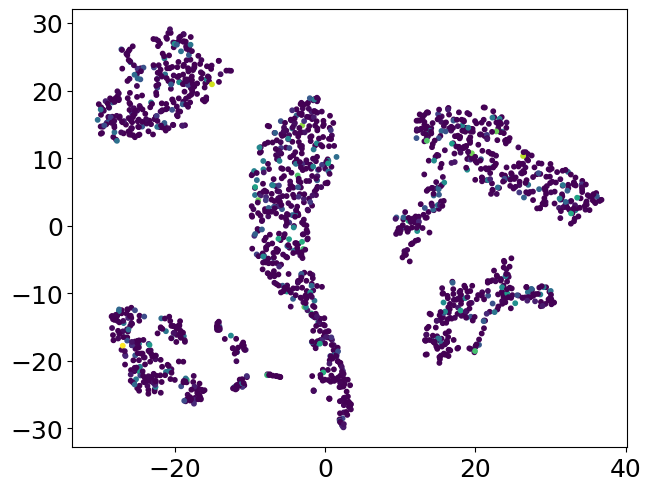

In [12]:
plt.scatter(rna.obs['_X'],rna.obs['_Y'],c=protein.X[:,2],s=10)

In [13]:
genes = np.array(protein.var_names,dtype=str)
genes

array(['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14',
       'CD11c', 'CD19'], dtype='<U6')

In [14]:
ensg_ids = []
# Example usage
for gene in genes:
    gene_name = gene
    ensg_id = get_ensg_id(gene_name)
    ensg_ids.append(ensg_id)
    if ensg_id:
        print(f"The ENSG ID for gene {gene_name} is: {ensg_id}")
    else:
        print(f"Failed to retrieve ENSG ID for gene {gene_name}")

Failed to retrieve ENSG ID for gene CD3
The ENSG ID for gene CD4 is: ENSG00000010610
The ENSG ID for gene CD8 is: ENSG00000153563
The ENSG ID for gene CD2 is: ENSG00000116824
Failed to retrieve ENSG ID for gene CD45RA
The ENSG ID for gene CD57 is: ENSG00000109956
The ENSG ID for gene CD16 is: ENSG00000203747
The ENSG ID for gene CD14 is: ENSG00000170458
The ENSG ID for gene CD11c is: ENSG00000140678
The ENSG ID for gene CD19 is: ENSG00000177455


In [15]:
ensg_ids[0] = 'ENSG00000167286' #CD3 delta
ensg_ids[4] = 'ENSG00000081237' #CD45 (PTPRC)
ensg_ids

['ENSG00000167286',
 'ENSG00000010610',
 'ENSG00000153563',
 'ENSG00000116824',
 'ENSG00000081237',
 'ENSG00000109956',
 'ENSG00000203747',
 'ENSG00000170458',
 'ENSG00000140678',
 'ENSG00000177455']

In [16]:
gene_idx = [ np.where(np.array(rna.var['Accession']) == ensg_id)[0][0] for ensg_id in ensg_ids]
gene_idx

[5211, 7261, 17878, 2370, 2828, 5325, 1090, 25619, 12428, 12355]

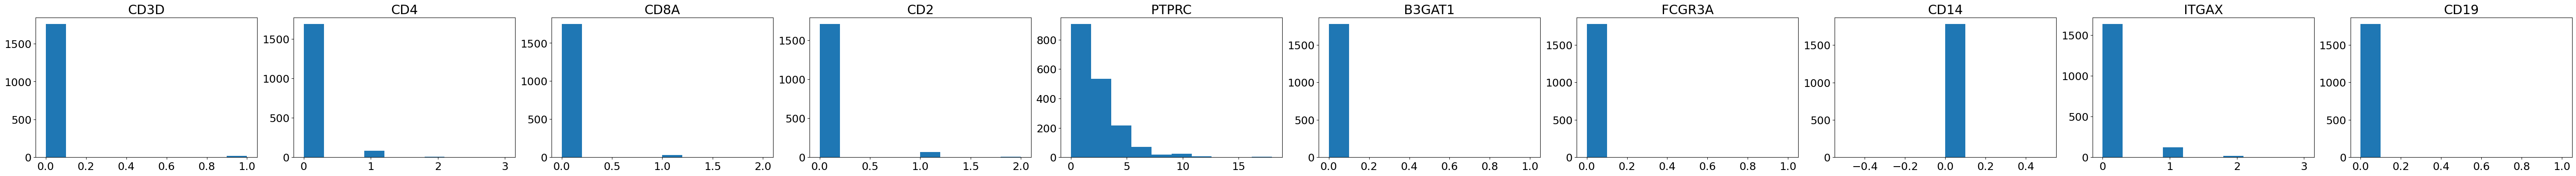

In [17]:
fig, ax = plt.subplots(1,10,figsize=(60,4))
i = 0
for idx in gene_idx:
    ax[i].set_title(rna.var_names[idx])
    ax[i].hist(rna.layers['unspliced'].toarray()[:,idx],bins=10);
    i = i+1

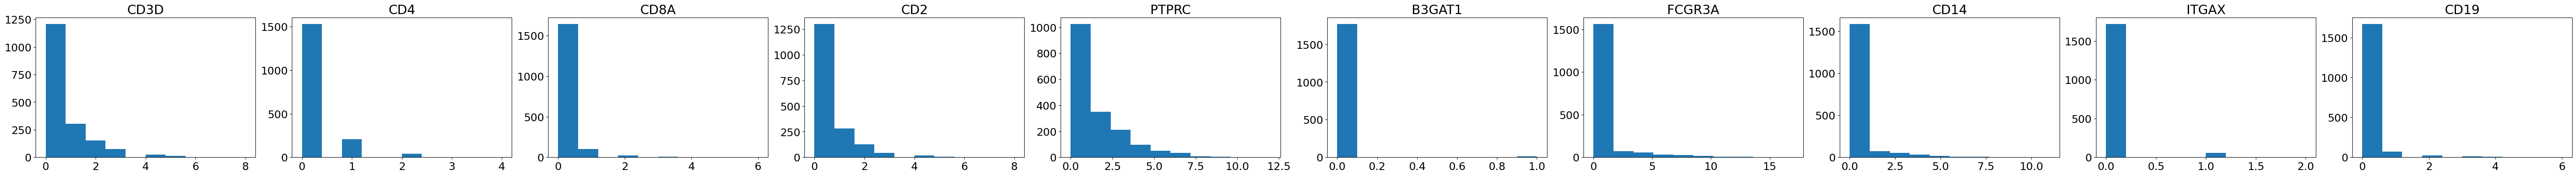

In [18]:
fig, ax = plt.subplots(1,10,figsize=(60,4))
i = 0
for idx in gene_idx:
    ax[i].set_title(rna.var_names[idx])
    ax[i].hist(rna.layers['spliced'].toarray()[:,idx],bins=10);
    i = i+1

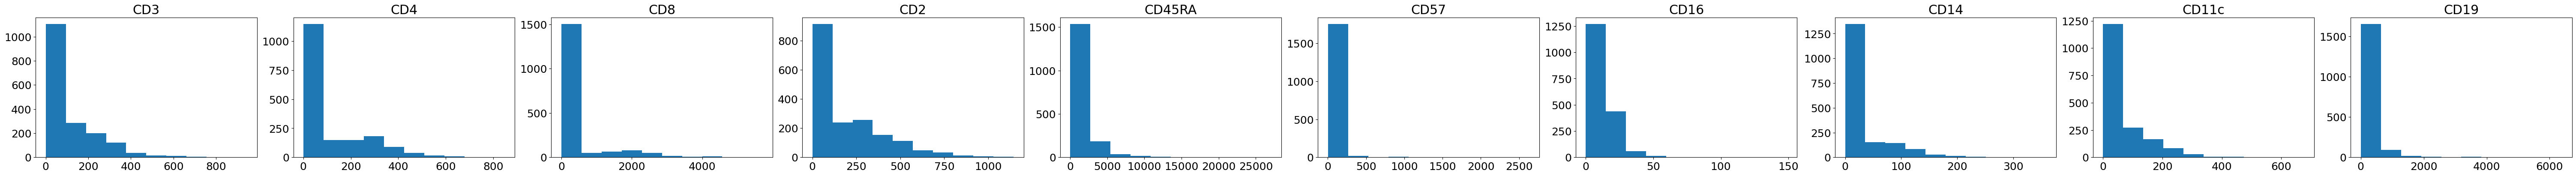

In [19]:
fig, ax = plt.subplots(1,10,figsize=(60,4))

for i in range(10):
    ax[i].set_title(protein.var_names[i])
    ax[i].hist(protein.X.toarray()[:,i],bins=10);
    i = i+1

## Calculate CV$^2$ of read depth

In [20]:
adata = rna

In [21]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
Clusters

{0, 1, 2, 3, 4, 5, 6}

0.04798218667278474 0.09198381934435698


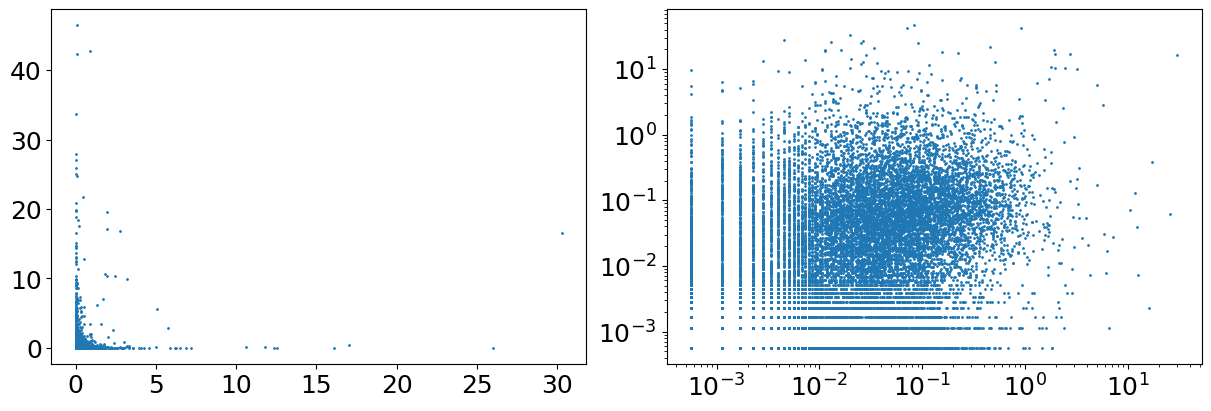

In [22]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

s estimated by total counts = 0.5231938274292306
5492 su= 0.3077979686273918
5224 ss= 0.35040148904379637
4339 s= 0.2899946917037161


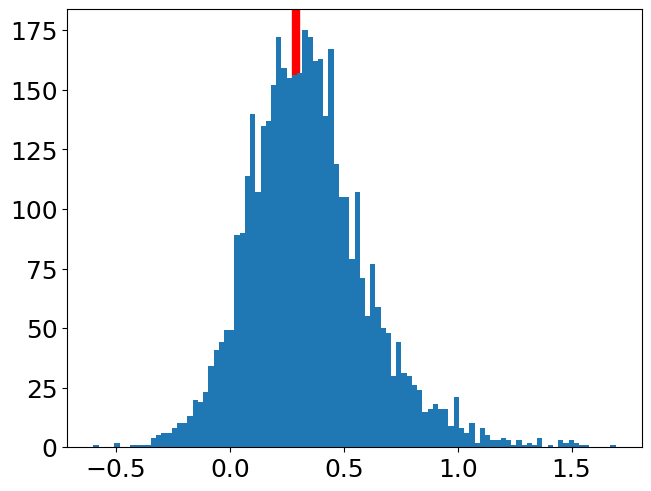

In [24]:
su, ss, sp = estimate_s(adata)

In [25]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.01) & (adata.layers["unspliced"].toarray().mean(0) > 0.01)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U.sum(),S.sum()

(2021370, 4215088)

Text(0.02, 0.5, 'CV$^2$')

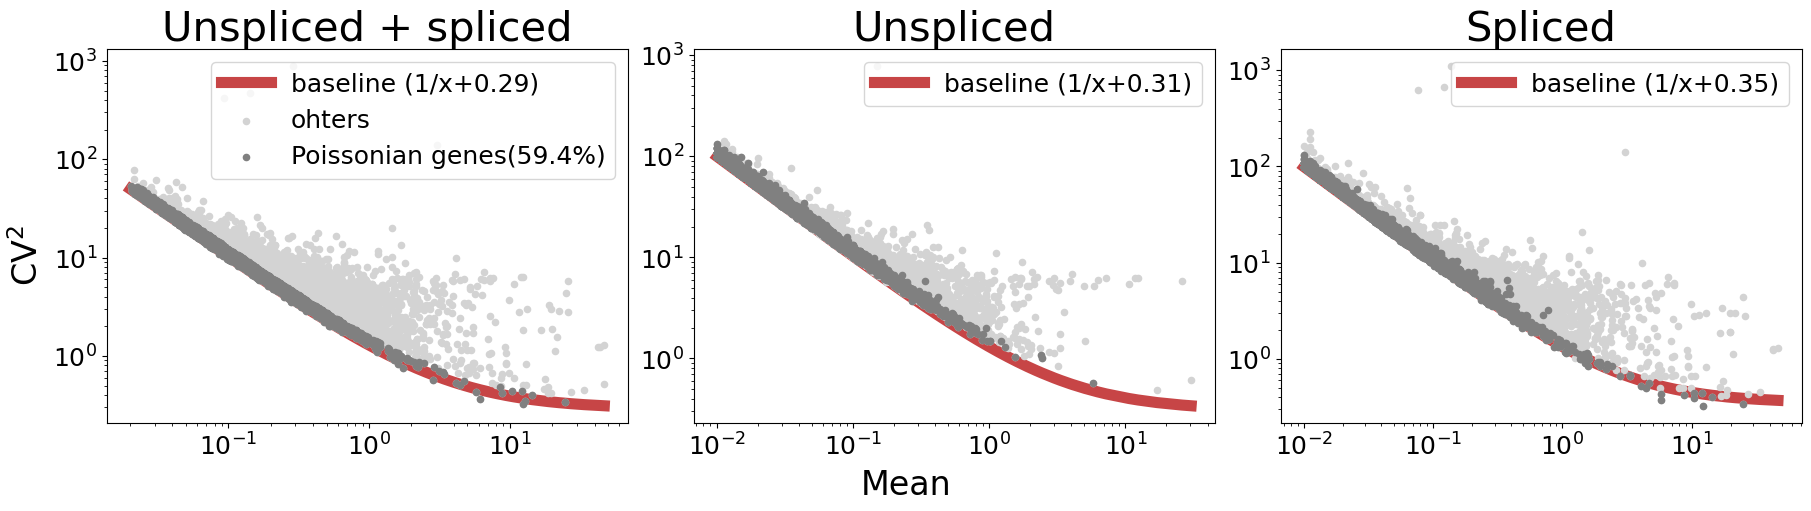

In [26]:
X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

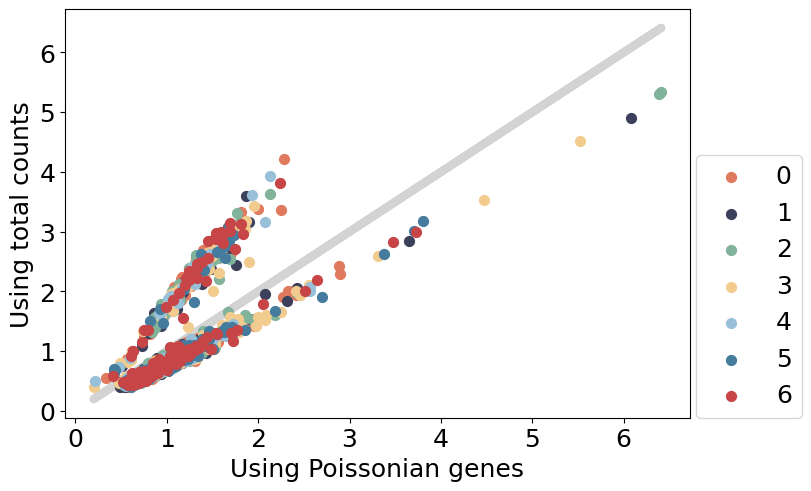

In [30]:
rd = X[:,Pgene_mask].mean(1)/X[:,Pgene_mask].mean()
rd_ = X.mean(1)/X.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster(i),alpha=1,s=50,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0),fontsize=legend_font)

## Select one cluster and calculate CV again

In [31]:
cell_idx = rd_ < rd 
adata = rna[cell_idx]
for i in Clusters:
    print(i,adata.obs['Clusters'].isin([i]).sum())

0 340
1 242
2 242
3 206
4 164
5 149
6 130


In [32]:
cluster_idx = (rd_ < rd) & (rna.obs['Clusters'].isin([0])) # 0, 4
adata = rna[cluster_idx]
adata

View of AnnData object with n_obs × n_vars = 340 × 33694
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

s estimated by total counts = 0.1557664066364793
4344 su= 0.1932676590811296
4989 ss= 0.17714582425789022
4236 s= 0.1695211289968568


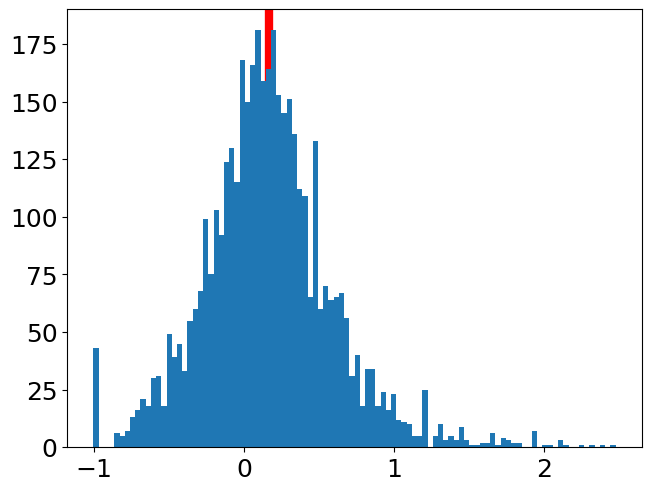

In [33]:
su, ss, sp = estimate_s(adata)

/tmp/ipykernel_1768016/1333339152.py:12: RuntimeWarning: invalid value encountered in divide
  Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)
/tmp/ipykernel_1768016/1333339152.py:15: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
/tmp/ipykernel_1768016/1333339152.py:16: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
/tmp/ipykernel_1768016/1333339152.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
/tmp/ipykernel_1768016/1333339152.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
/tmp/ipykernel_1768016/1333339152.py:25: 

Text(0.02, 0.5, 'CV$^2$')

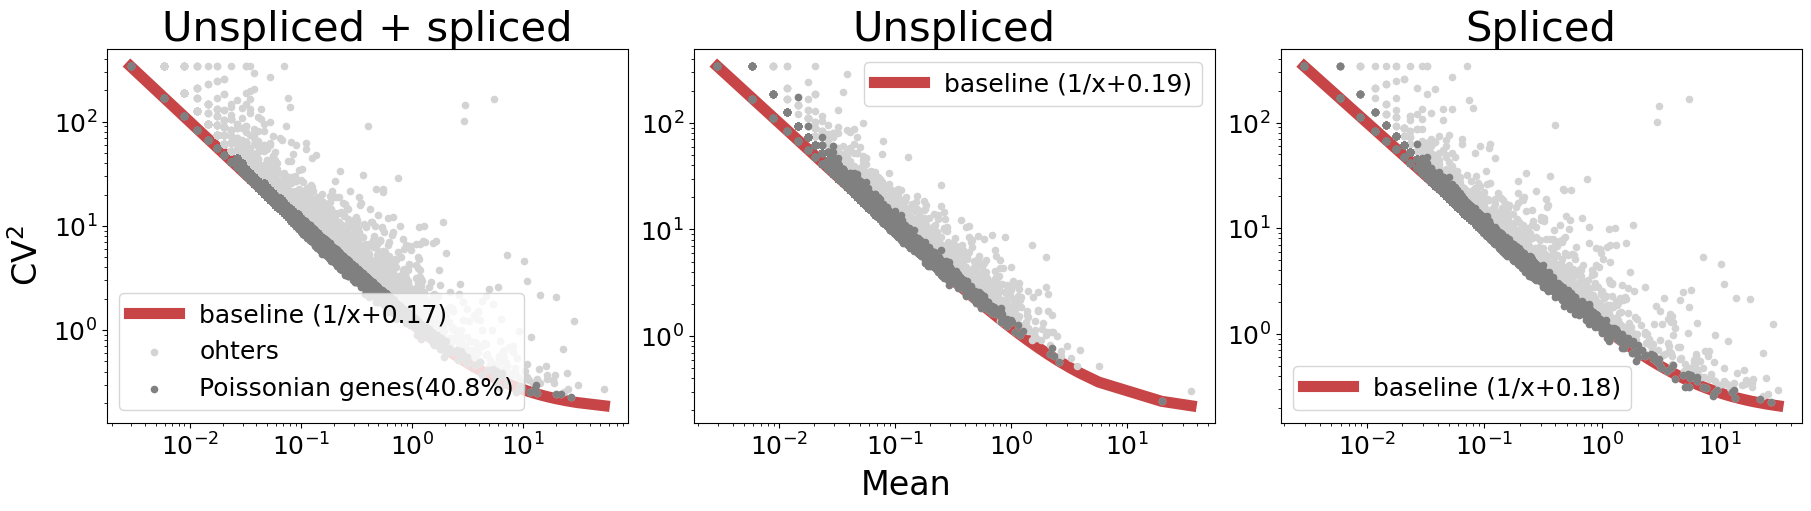

In [38]:
U = adata.layers["unspliced"].toarray()
S = adata.layers["spliced"].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

/tmp/ipykernel_1768016/213590174.py:12: RuntimeWarning: invalid value encountered in divide
  Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.5)
/tmp/ipykernel_1768016/213590174.py:16: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(X_mean, X_var/X_mean-sp*X_mean,c='lightgray',alpha=1, s=20)
/tmp/ipykernel_1768016/213590174.py:22: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
/tmp/ipykernel_1768016/213590174.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]-sp*U_mean[Pgene_mask], s=20, c='gray')
/tmp/ipykernel_1768016/213590174.py:28: RuntimeWarning: invalid value encountered in divide
  ax[2].scatter(S_mean, S_var/S_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
/tmp/ipykernel_1768016/213590174.py:29: RuntimeWarning: invalid value encountered in divide
  ax[2].scatt

Text(0.02, 0.5, 'CV$^2$')

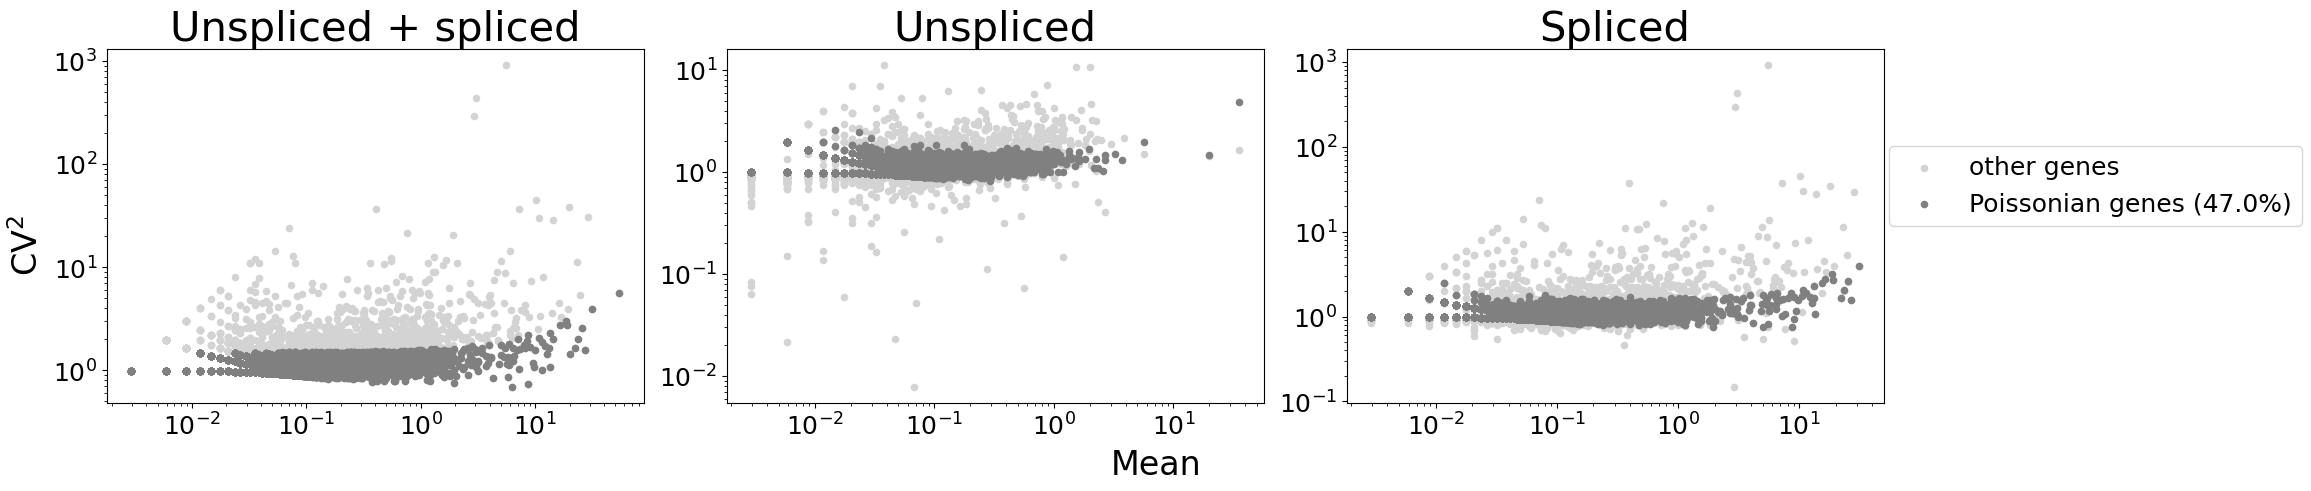

In [42]:
U = adata.layers["unspliced"].toarray()
S = adata.layers["spliced"].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.5) 

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].scatter(X_mean, X_var/X_mean-sp*X_mean,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask], s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].scatter(U_mean, U_var/U_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]-sp*U_mean[Pgene_mask], s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].scatter(S_mean, S_var/S_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]-sp*S_mean[Pgene_mask], s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

0.4701430521754615


/tmp/ipykernel_1768016/2162023319.py:6: RuntimeWarning: invalid value encountered in divide
  return var/mean-s*mean-1


Text(0.5, 1.0, 'U+S+A')

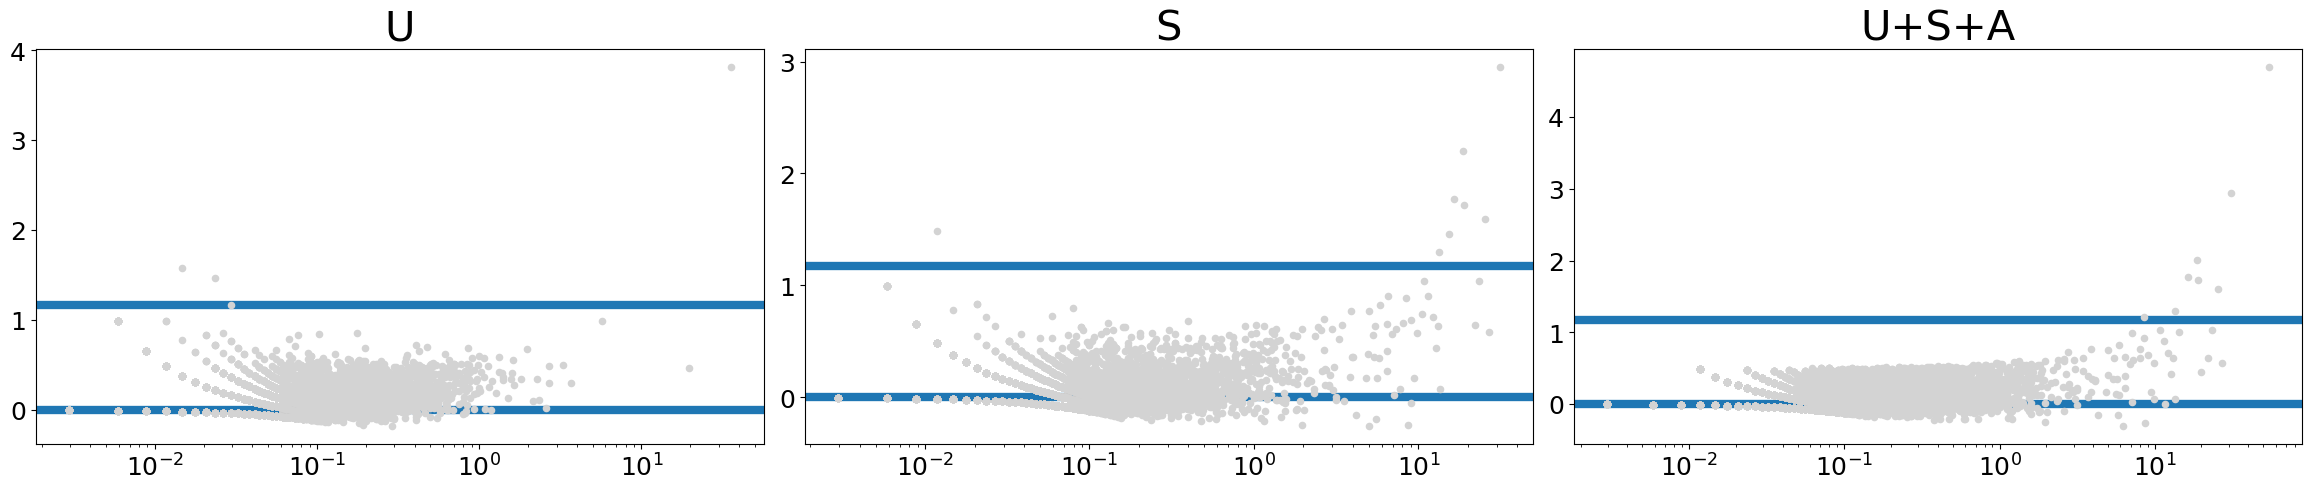

In [43]:
print(Pgene_mask.mean())
s=sp
def f(X):
    mean = np.mean(X,axis=0)
    var = np.var(X,axis=0)
    return var/mean-s*mean-1

fig, ax = plt.subplots(1,3,figsize=(23,4.8))
ax[0].scatter(U_mean[Pgene_mask], f(U[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[0].axhline(y=0,zorder=0)
ax[0].axhline(y=1+s,zorder=0)
ax[0].set_xscale('log')
ax[0].set_title('U',fontsize=title_font)

ax[1].scatter(S_mean[Pgene_mask], f(S[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[1].axhline(y=0,zorder=0)
ax[1].axhline(y=1+s,zorder=0)
ax[1].set_xscale('log')
ax[1].set_title('S',fontsize=title_font)

X_ = S + U 
ax[2].scatter(X_mean[Pgene_mask], f(X_[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[2].axhline(y=0,zorder=0)
ax[2].axhline(y=1+s,zorder=0)
ax[2].set_xscale('log')
ax[2].set_title('U+S+A',fontsize=title_font)

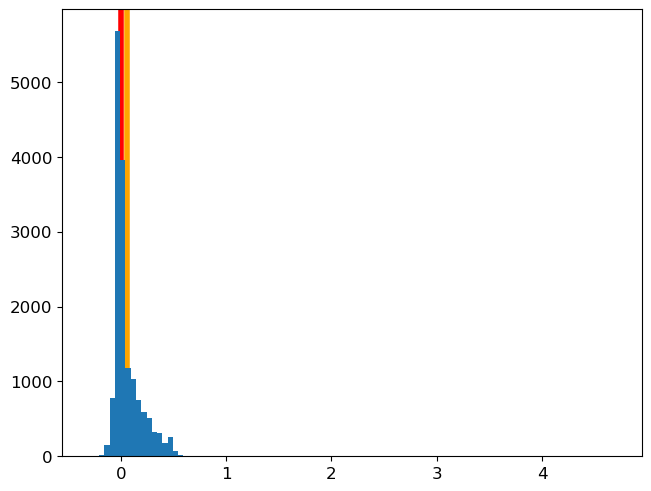

In [51]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.05*(1+s),c='orange',zorder=0)

# Check covariance relationships

In [72]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.2) & (adata.layers["unspliced"].toarray().mean(0) > 0.2)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(241,)

## Var(N_U)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


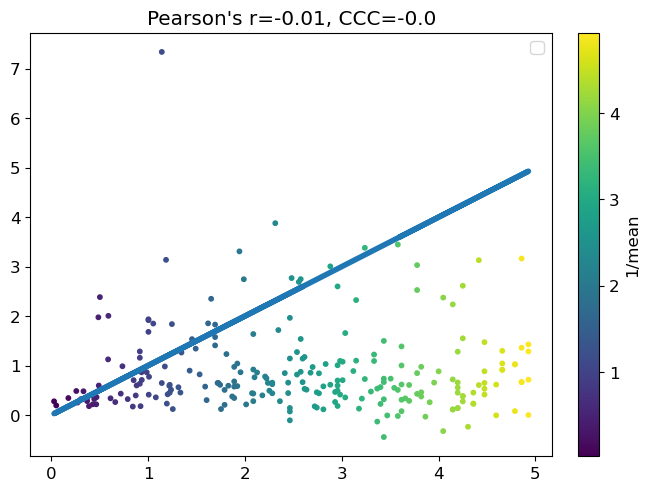

In [73]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=x)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

Text(0.5, 1.0, '95.85% of cells >= 0')

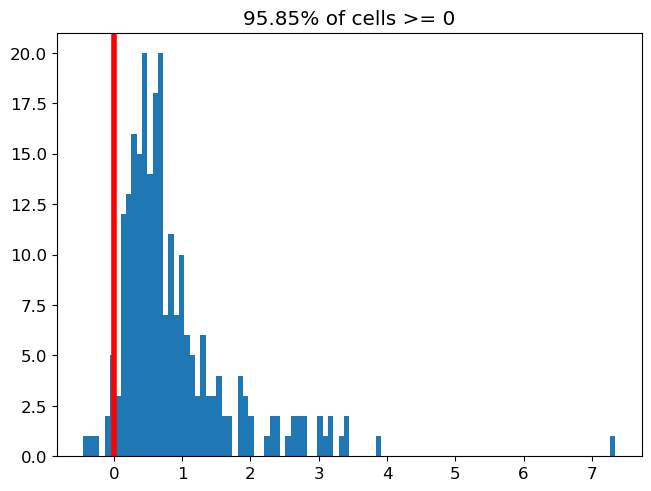

In [74]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

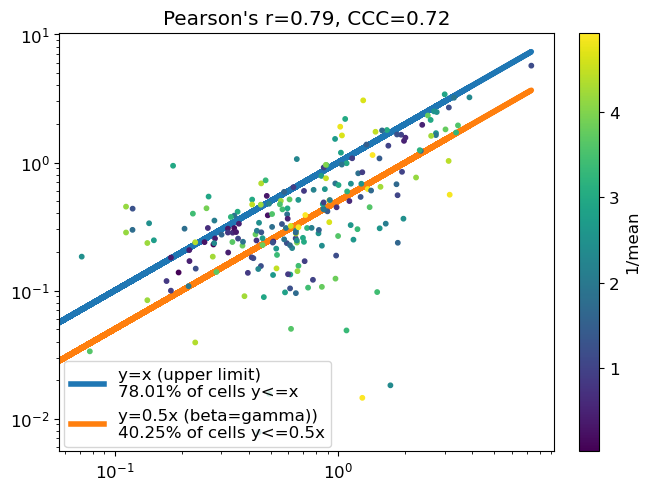

In [75]:
x=zeta_uu
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

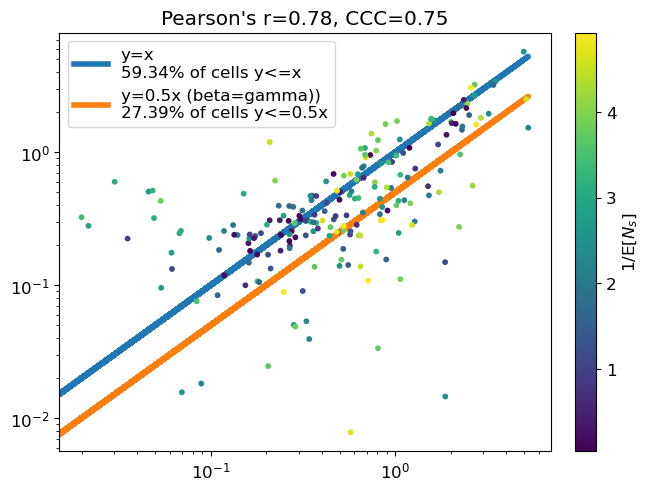

In [77]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

# Check protein varaince

In [78]:
U = adata.layers["unspliced"].toarray()[:,gene_idx]
S = adata.layers["spliced"].toarray()[:,gene_idx]
P = np.array(protein.X.toarray()[cluster_idx],dtype=int)
P.shape

(340, 10)

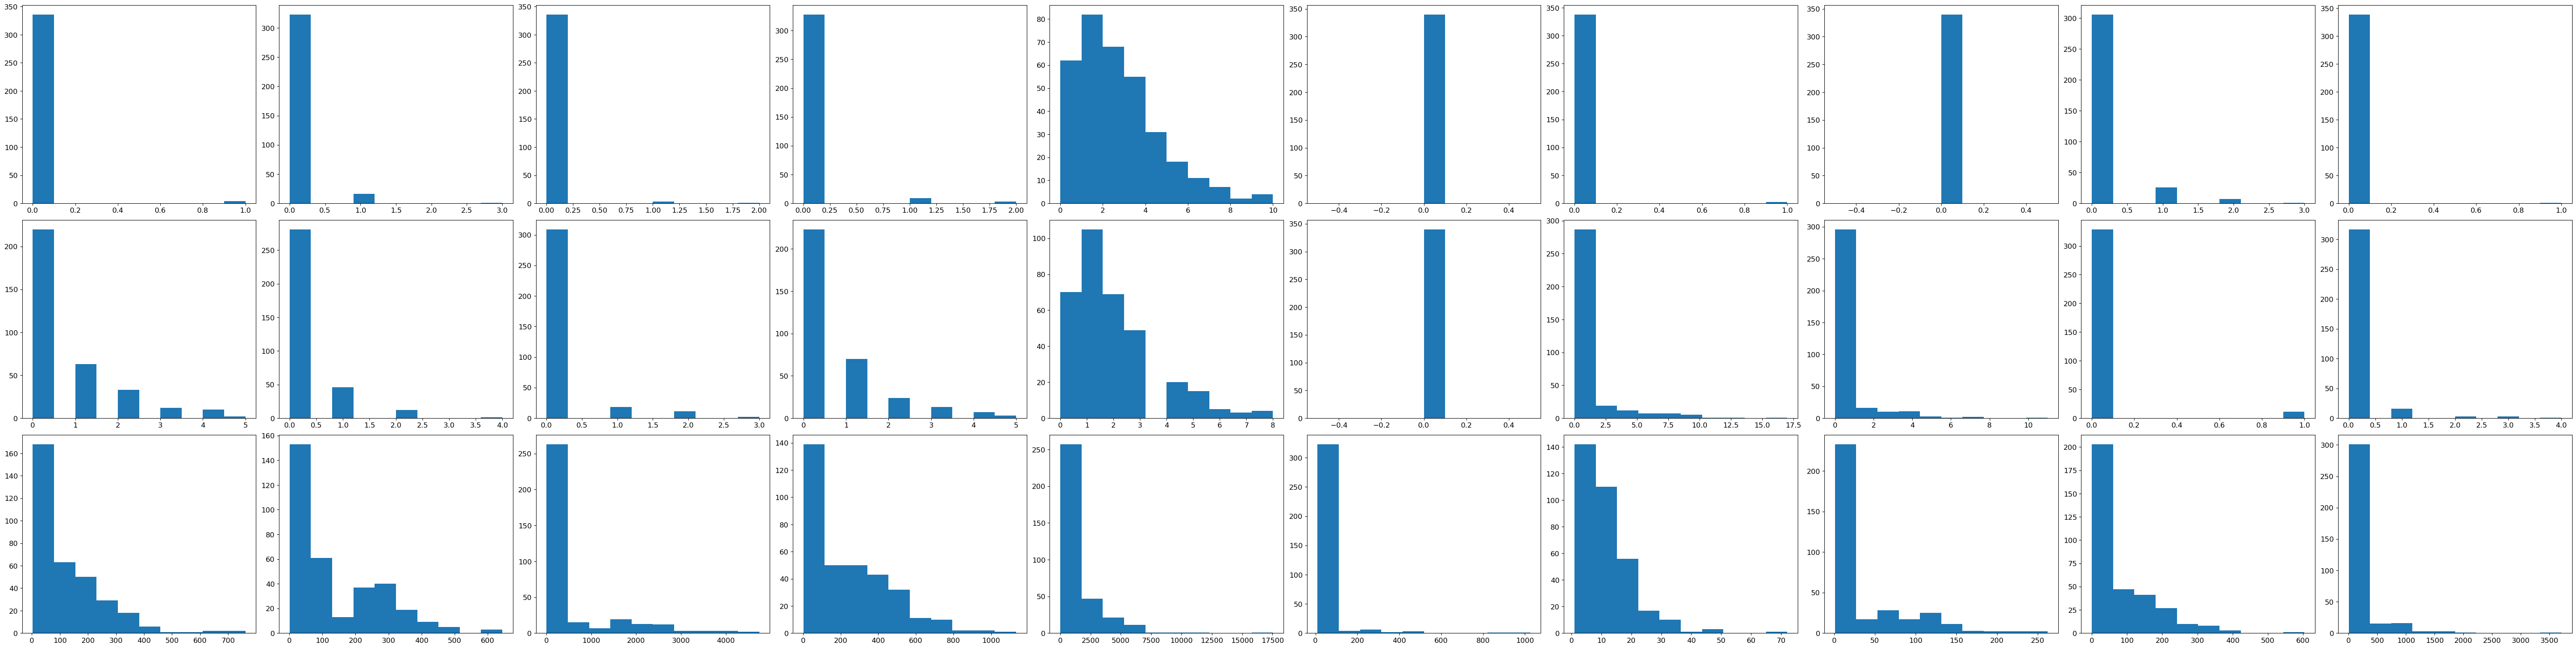

In [79]:
fig,ax = plt.subplots(3,10,figsize=(60,15))
for i in range(10):
    ax[0,i].hist(U[:,i])
    ax[1,i].hist(S[:,i])
    ax[2,i].hist(P[:,i])

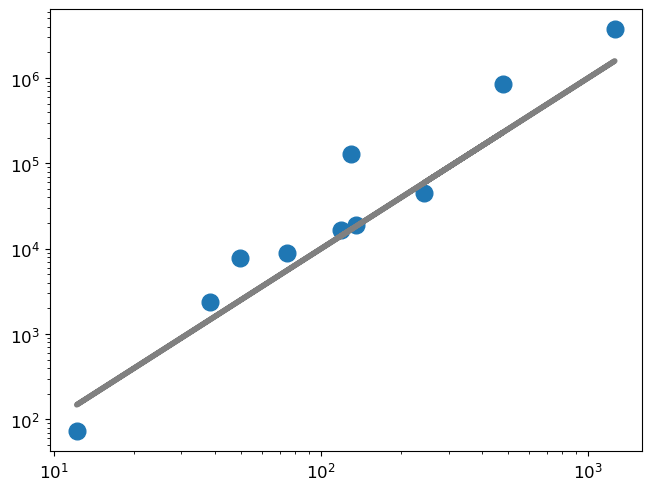

In [80]:
plt.scatter(P.mean(0),P.var(0))
plt.loglog(P.mean(0),P.mean(0)**2,'gray')

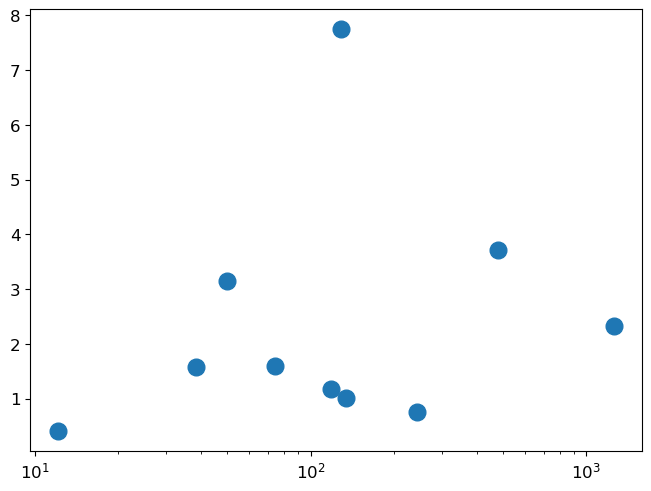

In [81]:
plt.scatter(P.mean(0),(P.var(0)-P.mean(0))/P.mean(0)**2)
plt.xscale('log')

In [82]:
iidx = (np.mean(U,axis=0)>0) &  (np.mean(S,axis=0)>0) &  (np.mean(P,axis=0)>0)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
cov_up = []
cov_sp = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_sp.append(np.cov(S[:,i],P[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)
zeta_up = (np.array(cov_up)/U_mean/P_mean)
zeta_sp = (np.array(cov_sp)/S_mean/P_mean)
zeta_us

array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
        8.00042836,  2.60173249,  8.73999157])

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [83]:
zeta_up,zeta_us

(array([ 1.23711101,  1.01301436,  3.68821146,  0.97593109,  0.20403315,
         0.06886793,  0.98604154, 14.22379148]),
 array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
         8.00042836,  2.60173249,  8.73999157]))

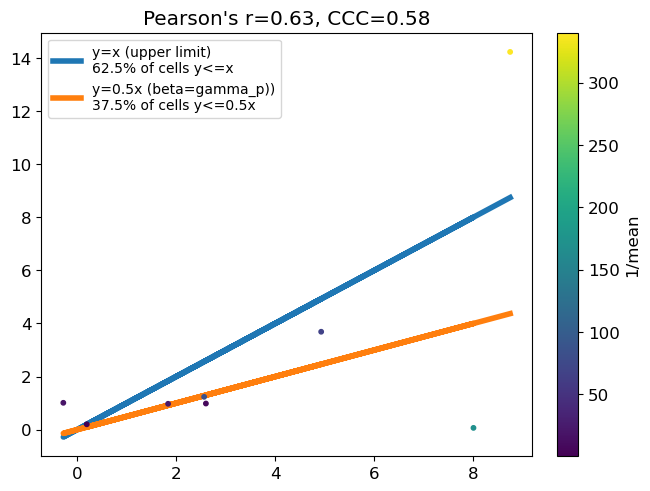

In [84]:
x=zeta_us
y=zeta_up

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma_p))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(fontsize=10)

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [85]:
zeta_up-zeta_sp,(zeta_up-zeta_sp)/(zeta_ss-zeta_sp)

(array([ 0.45357414,  0.65412781,  1.03778763,  0.33179173,  0.19208809,
        -0.60624778, -0.38086888,  5.6323643 ]),
 array([ 1.11074676,  0.74644718,  0.57250484,  0.50977384,  0.74721531,
        -0.12913643,  0.16091394, 14.06650829]))

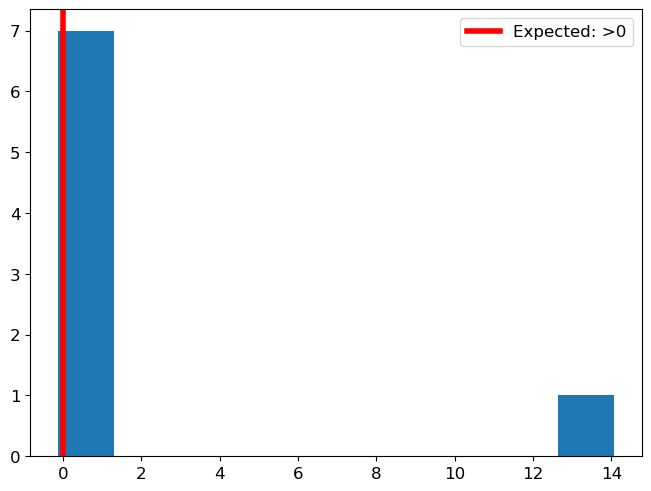

In [86]:
plt.hist((zeta_up-zeta_sp)/(zeta_ss-zeta_sp));
plt.axvline(x=0,c='r',label='Expected: >0')
plt.legend()

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

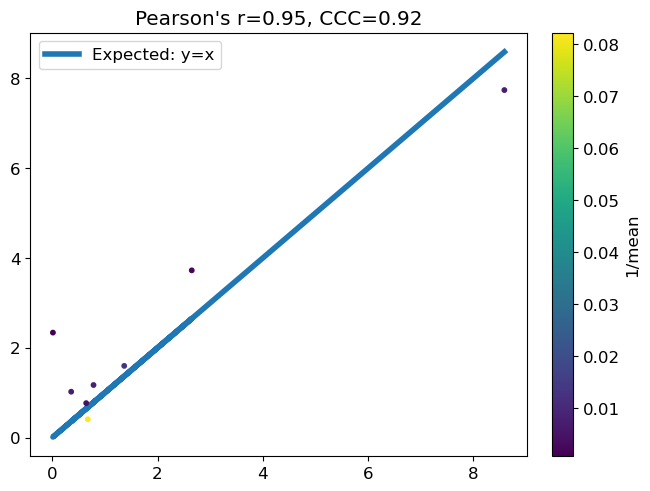

In [87]:
x=zeta_sp
y=zeta_pp

plt.plot(x,x,zorder=0,label='Expected: y=x')
plt.scatter(x,y,s=10,alpha=1,c=1/P_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()